##0 Imports & loading data

In [ ]:
import numpy as np 
import pandas as pd
from google.colab import files
from matplotlib import pyplot


from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


In [ ]:
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
df = pd.read_csv('train.csv')

##1 Data preprocessing 

###1.1 Mapping, deleting unnecessary features and missing values, getting dummies

In [ ]:
df = df.drop(['AnimalID','Name', 'DateTime','OutcomeSubtype','Color'], axis=1)
df = df.dropna()
print(df.isnull().sum())

OutcomeType       0
AnimalType        0
SexuponOutcome    0
AgeuponOutcome    0
Breed             0
dtype: int64


In [ ]:
def switch_age(argument):
    words = argument.split()
    #unit = re.sub("s", "", words[1])
    if(words[0]=='nan'):
      return 
    multiplayer = int(words[0])
    switcher = {
        'day' : 1,
        'days' : 1,
        'week' : 7,
        'weeks' : 7,
        'month' : 30,
        'months' : 30,
        'year' : 365,
        'years': 365
    }
    return multiplayer * switcher.get(words[1], 0)

df['AgeuponOutcome'] = df['AgeuponOutcome'].astype(str)
df['AgeuponOutcome'] = df['AgeuponOutcome'].map(switch_age)

In [ ]:
outcome_mapping = {label:idx for idx,label in enumerate(df['OutcomeType'].unique())}
df['OutcomeType'] = df['OutcomeType'].map(outcome_mapping)

In [ ]:
sex_mapping = {label:idx for idx,label in enumerate(df['SexuponOutcome'].unique())}
df['SexuponOutcome'] = df['SexuponOutcome'].map(sex_mapping)

sex2 = df['SexuponOutcome'].copy()
df['Neutred/Spayed'] = sex2

{'Intact Female': 3,
 'Intact Male': 2,
 'Neutered Male': 0,
 'Spayed Female': 1,
 'Unknown': 4}

In [ ]:
sex_bin_mapping = {0:'male',1:'female',2:'male',3:'female',4:'unknown'}    
neutred_mapping = {0:'neutred',1:'neutred',2:'intact',3:'intact',4:'intact'}

df['SexuponOutcome'] = df['SexuponOutcome'].map(sex_bin_mapping)
df['Neutred/Spayed'] = df['Neutred/Spayed'].map(neutred_mapping)


In [ ]:
df['IsMix'] = df['Breed'].str.contains('mix',case=False)
df = df.drop(['Breed'],axis=1)

is_mix_to_string = {True:'mix', False:'notmix'}
df['IsMix'] = df['IsMix'].map(is_mix_to_string)
df = pd.get_dummies(df)

In [ ]:
#df.head()

,OutcomeType,AgeuponOutcome,AnimalType_Cat,AnimalType_Dog,SexuponOutcome_female,SexuponOutcome_male,SexuponOutcome_unknown,Neutred/Spayed_intact,Neutred/Spayed_neutred,IsMix_mix,IsMix_notmix
0,0,365,0,1,0,1,0,0,1,1,0
1,1,365,1,0,1,0,0,0,1,1,0
2,2,730,0,1,0,1,0,0,1,1,0
3,3,21,1,0,0,1,0,1,0,1,0
4,3,730,0,1,0,1,0,0,1,0,1


###1.2 Dividing, standarization

In [ ]:
X = df.loc[:,'AgeuponOutcome':'IsMix_notmix']
y = df['OutcomeType']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0) #Setting random_state a fixed value will guarantee that same sequence of random numbers are generated each time you run the code.
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std=scaler.transform(X_test)


###1.3 Making one additional vector only for adoption outcome

In [ ]:
#outcome_mapping

{'Adoption': 2,
 'Died': 4,
 'Euthanasia': 1,
 'Return_to_owner': 0,
 'Transfer': 3}

In [ ]:
adopt_map = {2:1,4:0,1:0,0:0,3:0}
y_adopt_train = y_train.map(adopt_map)
y_adopt_test = y_test.map(adopt_map)

#2. Different models evaluation


###2.1 K nearest neighbours



In [ ]:
knn = KNeighborsClassifier(n_neighbors=5,p=1)
knn.fit(X_train_std,y_train)
y_pred_knn = knn.predict(X_test_std)
print('Accuracy: %3f' %accuracy_score(y_test,y_pred_knn))
print('Precision: %3f' %precision_score(y_test,y_pred_knn,average='micro'))
print('Precision for predicting adoption: %3f' %precision_score (y_adopt_test,np.vectorize(adopt_map.get)(y_pred_knn) ))

Accuracy: 0.567952
Precision: 0.567952
Precision for predicting adoption: 0.630291


###2.2 Kernel SVM

In [ ]:
svc = svm.SVC(kernel='poly', degree=4, C=1.0, random_state = 0)
svc.fit(X_train_std,y_train)
y_pred_svc = svc.predict(X_test_std)

print('Accuracy score: %3f' %accuracy_score(y_test, y_pred_svc))
# print('Precision: %3f' %precision_score(y_test,y_pred_svc,average='weighted'))
# print('Precision for predicting adoption: %3f' %precision_score (y_adopt_test,np.vectorize(adopt_map.get)(y_pred_svc) ))
print('F1 for predicting adoption: %3f' %precision_score (y_adopt_test,np.vectorize(adopt_map.get)(y_pred_svc) ))


Accuracy score: 0.630351


ValueError: ignored

In [ ]:
clf = svm.SVC()
scorer = make_scorer(f1_score,average='micro')
grid_values = {'kernel': ['poly','rbf'], 'degree':[3,4,5], 'C':[0.001,0.01,1]}
grid_clf = GridSearchCV(clf, param_grid=grid_values,scoring=scorer)
grid_clf.fit(X_train_std,y_train)
print(grid_clf.best_score_)
print(grid_clf.best_params_)

###2.3 Decision tree & random forest

In [ ]:
tree = DecisionTreeClassifier(criterion='gini', random_state=0)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print('Accuracy score: %2f' %accuracy_score(y_test, y_pred_tree))
print('Precision: %3f' %precision_score(y_test,y_pred_tree,average = 'micro'))
print('Precision for predicting adoption: %3f' %precision_score (y_adopt_test,np.vectorize(adopt_map.get)(y_pred_tree) ))
#pre_scorer = make_scorer(score_func=precision_score,pos_label=1,greater_is_better=True, average='micro')

Accuracy score: 0.629727
Precision: 0.629727
Precision for predicting adoption: 0.654723


In [ ]:
forest = RandomForestClassifier(criterion='gini', n_estimators=1000, random_state=1, n_jobs=2)
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)

print('Accuracy score: %2f' %accuracy_score(y_test, y_pred_forest))
print('Precision: %3f' %precision_score(y_test,y_pred_forest,average = 'micro'))
print('Precision for predicting adoption: %3f' %precision_score (y_adopt_test,np.vectorize(adopt_map.get)(y_pred_forest) ))

Accuracy score: 0.630850
Precision: 0.630850
Precision for predicting adoption: 0.653990


###2.4 XGBoost

In [ ]:
xgb_clas = xgb.XGBClassifier()
xgb_clas.fit(X_train,y_train)
y_pred_xgb = xgb_clas.predict(X_test)
print('Accuracy score: %2f' %accuracy_score(y_test, y_pred_xgb))
print('Precision: %3f' %precision_score(y_test,y_pred_xgb,average = 'micro'))
print('Precision for predicting adoption: %3f' %precision_score (y_adopt_test,np.vectorize(adopt_map.get)(y_pred_xgb) ))

Accuracy score: 0.630351
Precision: 0.630351
Precision for predicting adoption: 0.637347


In [ ]:
skf = StratifiedKFold(n_splits=15, random_state=1)
skf.get_n_splits(X_train, y_train)
k=0
scores=[]

for train, test in skf.split(X_train,y_train):
  k=k+1
  xgb_clas.fit(X_train[train],y_train.iloc[train])
  preds = xgb_clas.predict(X_train[test])
  score = precision_score(preds,y_train.iloc[test],average='micro') #xgb_clas.score(X_train[test], y_train.iloc[test])
  score2 = precision_score (y_train.iloc[test].map(adopt_map),np.vectorize(adopt_map.get)(preds) )
  scores.append(score)
  print('Fold: %s, Prec: %.3f, Prec. for adoption: %3f' % (k, score,score2))

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


Fold: 1, Prec: 0.633, Prec. for adoption: 0.627692
Fold: 2, Prec: 0.635, Prec. for adoption: 0.631579
Fold: 3, Prec: 0.635, Prec. for adoption: 0.626801
Fold: 4, Prec: 0.624, Prec. for adoption: 0.623512
Fold: 5, Prec: 0.649, Prec. for adoption: 0.639053
Fold: 6, Prec: 0.635, Prec. for adoption: 0.647321
Fold: 7, Prec: 0.645, Prec. for adoption: 0.636501
Fold: 8, Prec: 0.652, Prec. for adoption: 0.661442
Fold: 9, Prec: 0.638, Prec. for adoption: 0.633824
Fold: 10, Prec: 0.664, Prec. for adoption: 0.664134
Fold: 11, Prec: 0.614, Prec. for adoption: 0.627119
Fold: 12, Prec: 0.639, Prec. for adoption: 0.638849
Fold: 13, Prec: 0.626, Prec. for adoption: 0.615044
Fold: 14, Prec: 0.614, Prec. for adoption: 0.597421
Fold: 15, Prec: 0.630, Prec. for adoption: 0.633234
CV accuracy: 0.636 +/- 0.013


In [ ]:
preds = xgb_clas.predict(X_test)
print('Accuracy score: %2f' %accuracy_score(y_test, preds))
print('Precision: %3f' %precision_score(y_test,preds,average = 'micro'))
print('Precision for predicting adoption: %3f' %precision_score (y_adopt_test,np.vectorize(adopt_map.get)(preds) ))

Accuracy score: 0.628728
Precision: 0.628728
Precision for predicting adoption: 0.631847


In [ ]:
clf=xgb.XGBClassifier()
scorer = make_scorer(precision_score,average='micro')
grid_values = {'max_depth':[3,5,10], 'learning_rate':[0.1,0.5,1], 'n_estimators':[10,50,100,500]}
grid_clf = GridSearchCV(clf, param_grid=grid_values,scoring=scorer)
grid_clf.fit(X_train,y_train)
print(grid_clf.best_score_)
print(grid_clf.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.6374284644595389
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


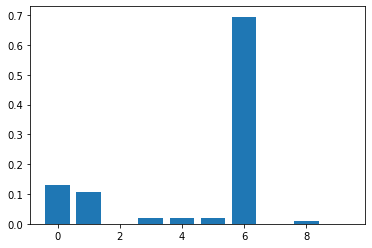

In [ ]:
clf.fit(X_train,y_train)
pyplot.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
pyplot.show()
